# Interpret embedding Results

## Imports, Settings, Data

In [1]:
import sys
sys.path.insert(0, "/home/jupyter/ML_for_slideseq")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import torchvision
import pytorch_lightning as pl
import lightly
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from tissue_purifier.util_data import *

/opt/conda/lib/python3.7/site-packages/lightly/api/version_checking.py:57: Warning: You are using lightly version 1.1.12. There is a newer version of the package available. For compatability reasons, please upgrade your current version: pip install lightly==1.1.13
  warnings.warn(Warning(warning))


In [19]:
# options
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use("seaborn")
mpl.rcParams["figure.dpi"] = 200
# warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
root = "/home/jupyter/data/slide-seq/original_data/"
# root = "/data/"

df_wt1 = pd.read_csv(root + "wt_1.csv")
df_wt2 = pd.read_csv(root + "wt_2.csv")
df_wt3 = pd.read_csv(root + "wt_3.csv")
df_dis1 = pd.read_csv(root + "sick_1.csv")
df_dis2 = pd.read_csv(root + "sick_2.csv")
df_dis3 = pd.read_csv(root + "sick_3.csv")

In [5]:
num_workers = 8
batch_size = 256
seed = 1
max_epochs = 100
input_size = 224
num_ftrs = 128
pixel_size = 5
crop_size = 224
input_channels = 9
n_element_min = 200

In [6]:
# all_df = [df_wt1, df_wt2, df_wt3, df_dis1, df_dis2, df_dis3]
all_df = [df_wt1, df_wt2, df_dis1, df_dis2]
sparse_images = [
    SparseImage.from_panda(
        df, x="x", y="y", category="cell_type", pixel_size=pixel_size, padding=10
    ) 
    for df in all_df
]

number of elements ---> 31659
The dense shape of the image is -> torch.Size([9, 938, 939])
number of elements ---> 33059
The dense shape of the image is -> torch.Size([9, 940, 680])
number of elements ---> 27194
The dense shape of the image is -> torch.Size([9, 937, 940])
number of elements ---> 42776
The dense shape of the image is -> torch.Size([9, 940, 940])


In [7]:
# labels_sparse_images = ["wt1", "wt2", "wt3", "dis1", "dis2", "dis3"]
# labels_sparse_images = [0, 0, 1, 1 ]
# labels_sparse_images = [4]
# labels_sparse_images = [0, 0, 0 , 1, 1, 1]
labels_sparse_images = [0, 1, 2, 3,]

In [8]:
n_crops_test = 150

testdata_transform = torchvision.transforms.Compose([
    StackTensor(dim=-4),
    RandomGaussianBlur(sigma=(1.0, 1.0)),
    torchvision.transforms.Resize(input_size)
])

testdataset = SparseDataset(
    x=RandomCropSparseTensor(
        n_crops=n_crops_test,
        crop_size=crop_size,
        n_element_min=n_element_min,
        test_cache_key="test"
    )(sparse_images), 
    y=Interleave(n_repeat=n_crops_test)(labels_sparse_images)
)

dataloader_test = DataLoaderWithLoad(
    testdataset,
    batch_size=batch_size,
    collate_fn=SpecialCollateFn(transform=testdata_transform, simclr_output=False),
    shuffle=False
)

## Image Crops to Raw Crops

In [20]:
from simple_cache import cache

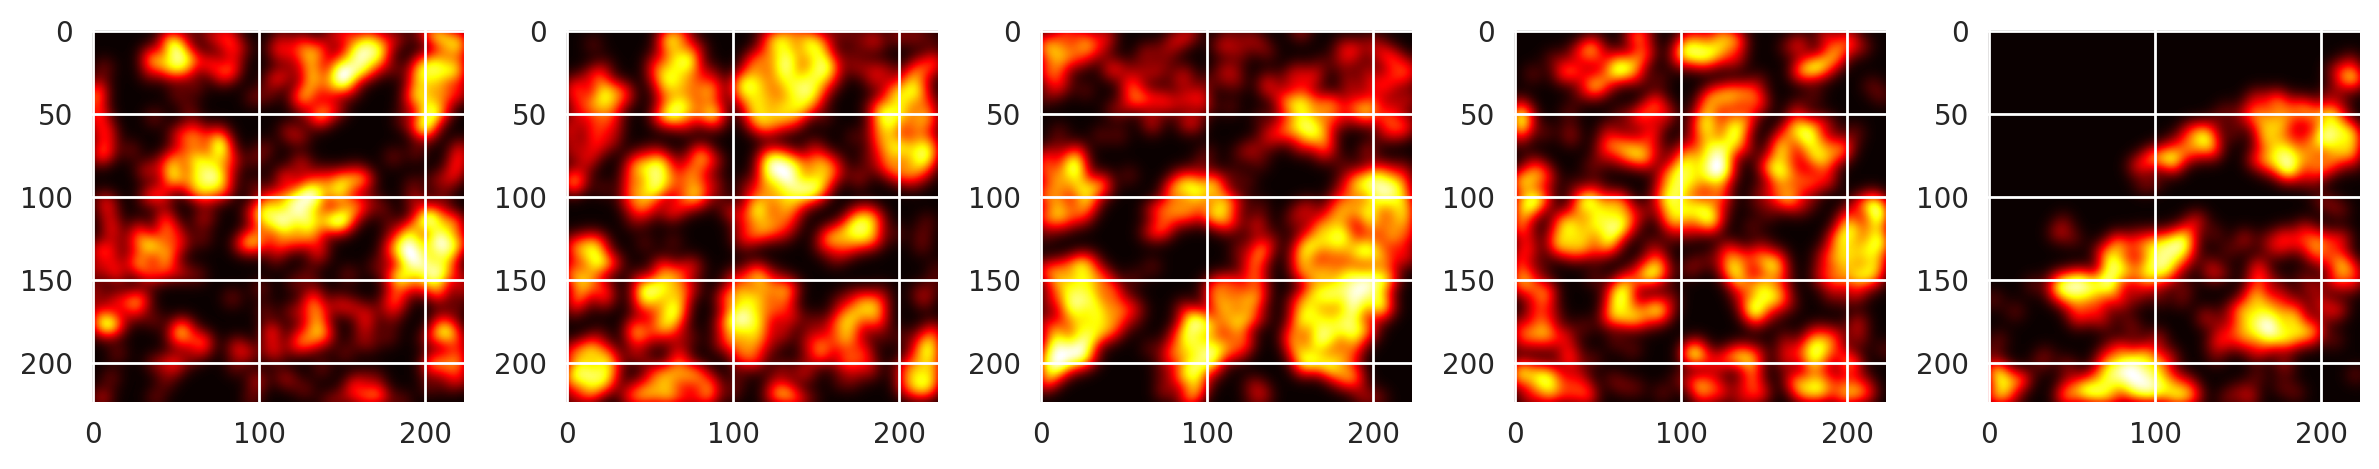

In [40]:
imgs, labels, indicies = next(iter(dataloader_test))
# print(imgs.shape, labels.shape, fname.shape)
show_tensor(imgs[:5, 0], figsize=(12,4), n_col=5, cmap='hot', normalize_range=(0.0, 1.0))

In [41]:
imgs.shape

torch.Size([256, 9, 224, 224])

In [42]:
# sample_indicies = [0, 1, 2, 3] * n_crops_test
sample_indicies = labels_sparse_images * n_crops_test
sample_indicies.sort()

In [43]:
first = sparse_images[sample_indicies[indicies[0]]].data.to_dense().cpu().numpy()

In [44]:
# raw_coords = sparse_images[0].pixel_to_raw(cache["test"][:5][:,0], cache["test"][:5][:, 1])

In [45]:
def plot_spatial_crop(df, pixel_size, x, y):
    x_t = x.item() * pixel_size + df.x.min() - 10 * 5
    y_t = y.item() * pixel_size + df.y.min() - 10 * 5
    plt.figure(figsize=(7, 7))
    a = df[
        (df.x > x_t) 
        & (df.y > y_t) 
        & (df.x < x_t + (crop_size * pixel_size)) 
        & (df.y < y_t + (crop_size * pixel_size))
    ]
    a = a[a.cell_type == 1]
    plt.scatter(a.x, a.y, c=a.cell_type, s=50)
    plt.show()
    
def plot_raster_crop(x, y, sample):
    plt.figure(figsize=(7, 7))
    crop = np.rot90(sample[0, x_:x_ + crop_size, y_: y_ + crop_size])
    plt.imshow(crop, cmap="hot")

In [46]:
x_, y_ = cache["test"][indicies[0]]

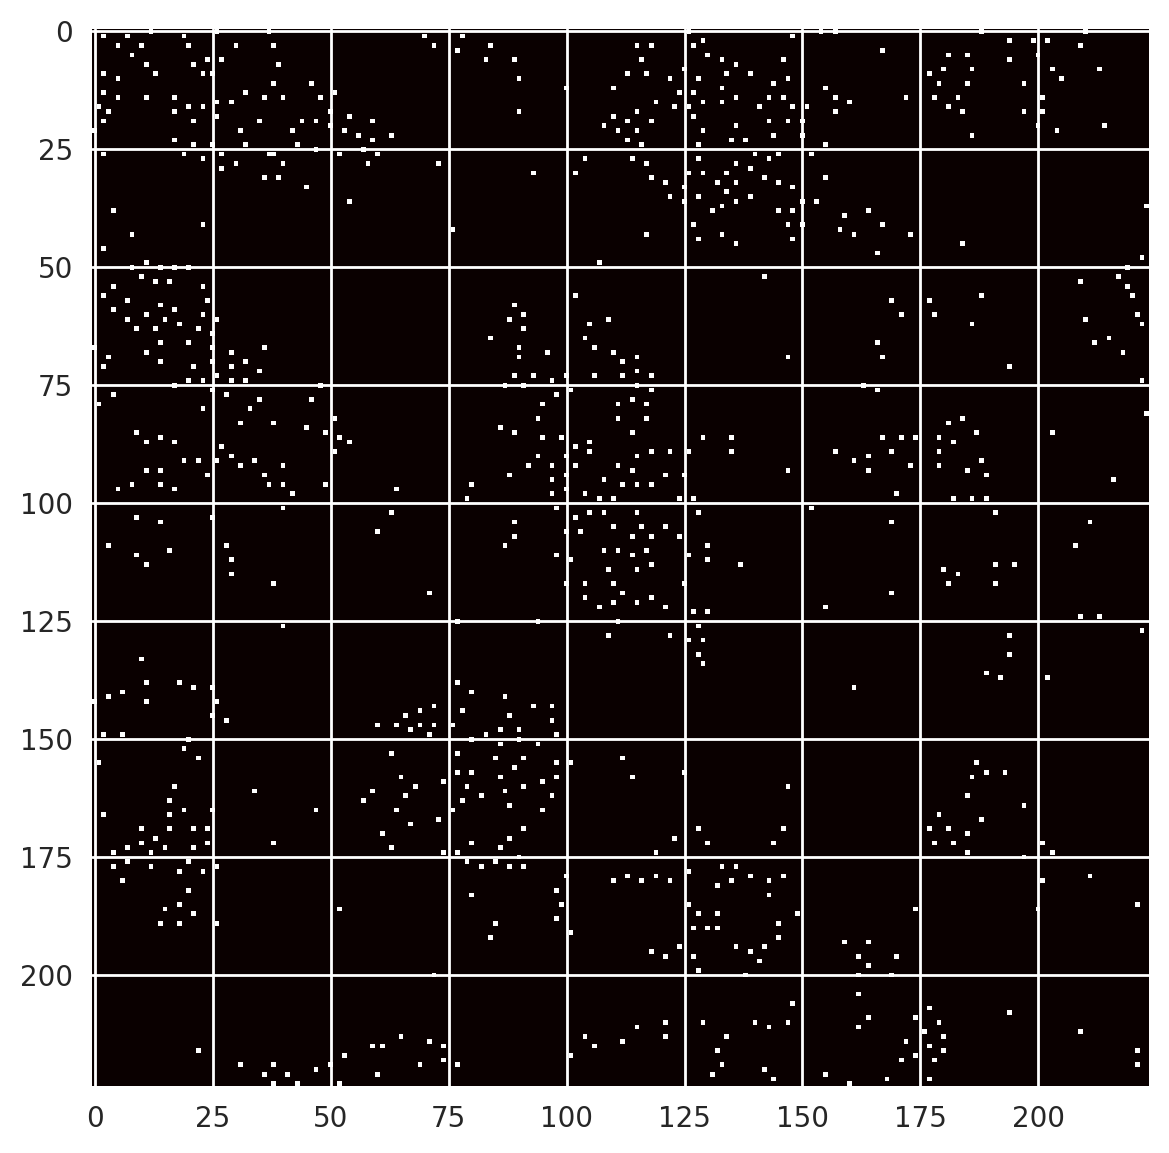

In [47]:
plot_raster_crop(x_, y_, first)

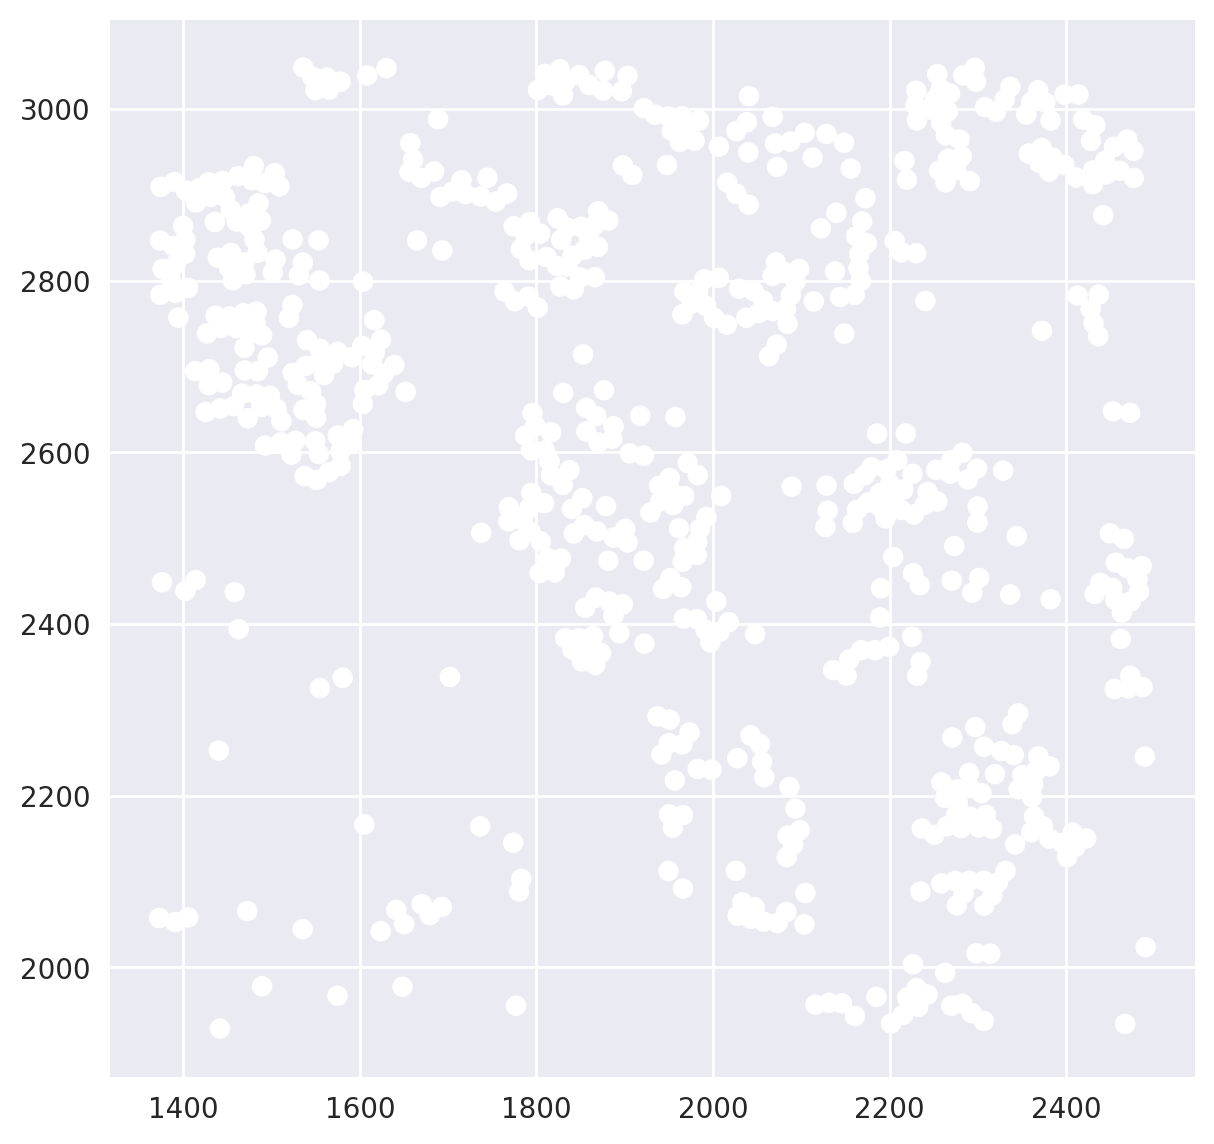

In [31]:
plot_spatial_crop(df_dis1, 5, x_, y_)

### SimCLR model, Embeddings

In [9]:
from torch import nn
import torchvision

resnet = torchvision.models.resnet18()
last_conv_channels = list(resnet.children())[-1].in_features
first_conv_out_channels = list(resnet.children())[0].out_channels
backbone = torch.nn.Sequential(
    torch.nn.Conv2d(input_channels, first_conv_out_channels, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
    *list(resnet.children())[1:-1],
    torch.nn.Conv2d(last_conv_channels, num_ftrs, 1),
)

ckpt = torch.load('model.pth')
backbone.load_state_dict(ckpt['resnet18_parameters'])
# create the SimCLR model using the loaded created backbone
model = lightly.models.SimCLR(backbone, num_ftrs=num_ftrs)

In [10]:
# model

In [11]:
import torch
import lightly
from src import models

criterion = lightly.loss.NTXentLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=[0.9, 0.999])

encoder = lightly.embedding.SelfSupervisedEmbedding(
# encoder = models.ProjectionHeadEmbedding(
    model,
    criterion,
    optimizer,
    dataloader_test
)

In [12]:
# device = 'cuda' if gpus==1 else 'cpu'
device = "cuda"
encoder = encoder.to(device)

embeddings, labels, fnames = encoder.embed(dataloader_test, device=device, to_numpy=True)

Compute efficiency: 0.01: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


In [13]:
embeddings.shape

(600, 128)

In [14]:
# embeddings_df = pd.DataFrame(embeddings)
# embeddings_df["label"] = labels
# embeddings_df

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

import torchvision
import pytorch_lightning as pl
import lightly
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from tissue_purifier.util_data import *

In [10]:
def plot_knn_examples(embeddings, dataloader: DataLoaderWithLoad, n_neighbors=3, num_examples=6, figsize=(6,6)):
    """
    Select some random examples and show the their nearest neighbors
    """
    
    # For each sample get n_neighbours indices and distances 
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    nbrs_distances, nbrs_indices = nbrs.kneighbors(embeddings)  # shape: len_dataset, n_neighbours
   
    # get some random samples
    samples_idx = numpy.random.choice(nbrs_indices.shape[0], size=num_examples, replace=False)
    
    # plot the randomly picked examples and their neighbours
    fig, ax = plt.subplots(ncols=n_neighbors, nrows=num_examples, figsize=figsize) 
    for r, idx in enumerate(samples_idx):
        indeces = list(nbrs_indices[idx])
        distances = list(nbrs_distances[idx])
        tensors, labels, fnames = dataloader.load(index=indeces)
        # print(tensors.shape) # n_neighbours, ch, w, h
        for c in range(n_neighbors):
            #img = tensors[c,0].cpu().numpy() # plot just the first 3 channels
            img = tensors[c,:3].permute(1,2,0).cpu().numpy() # plot just the first 3 channels
            img = (img - numpy.min(img))/(numpy.max(img)-numpy.min(img))
            ax[r,c].imshow(img)  
            ax[r,c].set_title(f'd={distances[c]:.3f}')
            ax[r,c].set_axis_off()
    plt.close(fig)
    return fig 

In [19]:
img = plot_knn_examples(embeddings, dataloader_test, n_neighbors=10, num_examples=30, figsize=(20,80))

In [19]:
img.savefig("./knn_embeddings.png")

## UMAP

In [16]:
import umap
from sklearn.preprocessing import StandardScaler


reducer = umap.UMAP(n_neighbors=20, min_dist=0.000001, metric="cosine")
scaled_embeddings = StandardScaler().fit_transform(embeddings)
umap_embedded = reducer.fit_transform(scaled_embeddings)

In [17]:
# plt.style.use("seaborn")

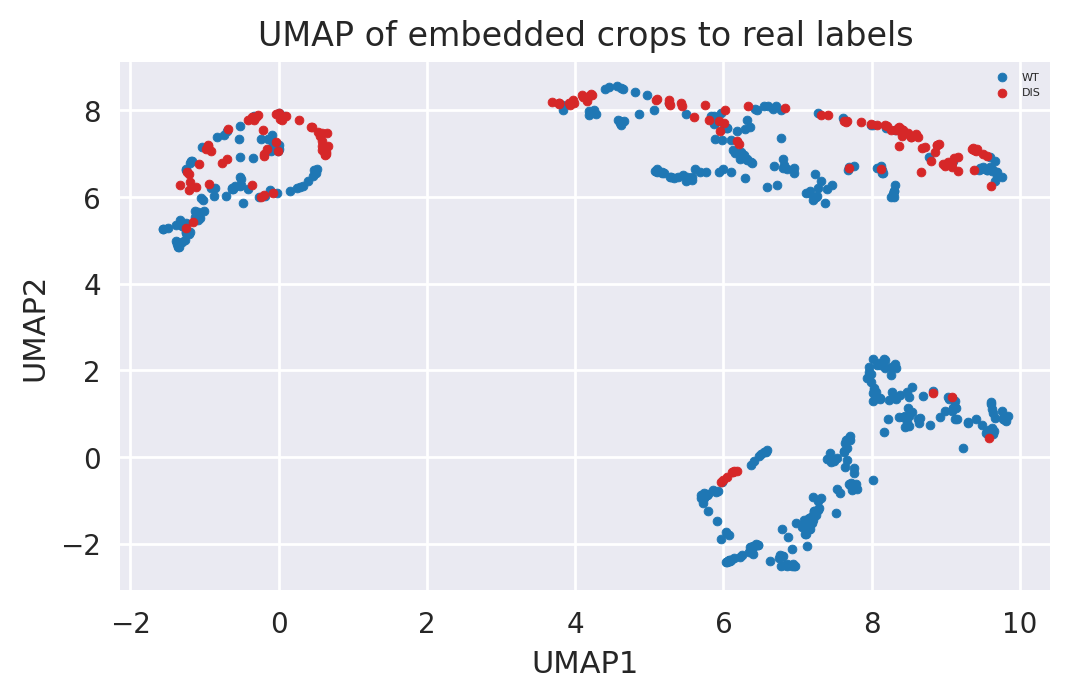

In [20]:
sample_indicies = labels
fig = plt.figure(figsize=(6, 3.5))

conditions = [0, 0, 0, 1, 1, 1]
scatters = []

for sample in pd.Series(sample_indicies).unique():
    sample_umap = umap_embedded[sample_indicies==sample, :]
    condition = conditions[sample]
    color = "tab:red" if condition == 1 else "tab:blue"
    scatt = plt.scatter(sample_umap[:, 0], sample_umap[:, 1], label="WT" if condition == 0 else "DIS", s=10, c=color)
    scatters.append(scatt)

# plt.scatter(umap_embedded[labels == 0, 0], umap_embedded[labels == 0, 1], label="WT", c="tab:blue", s=10, alpha=0.5)
# plt.scatter(umap_embedded[labels == 1, 0], umap_embedded[labels == 1, 1], label="DIS", c="tab:red", s=10, alpha=0.5)
plt.legend([scatters[0], scatters[3]], ["WT", "DIS"], fontsize=4)
# plt.legend()
plt.title("UMAP of embedded crops to real labels")
# plt.xticks([])
# plt.yticks([])
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()
fig.savefig("UMAP or label")

## Moran Score

In [21]:
from anndata import AnnData
import squidpy as sq
from sklearn.preprocessing import OneHotEncoder

def calculate_morans_score(df):
#     if df.shape[0] < 20:
#         return None
    features = OneHotEncoder().fit_transform(df[["cell_type"]]).toarray()
    coords = df[["x", "y"]].to_numpy()
    obs = pd.DataFrame(df["cell_type"])
    adata = AnnData(X=features, obsm={"spatial": coords}, obs=obs)
    sq.gr.spatial_neighbors(adata)
    sq.gr.moran(adata, show_progress_bar=False)
    return adata.uns["moranI"].sort_index()

In [22]:
from simple_cache import cache


def get_morans(dataloader):
    """
        Calculate Morans scores for dataloader. 
        Works only when labels corresponds to indicies of df from `all_df`
    """
    crop_coords = cache["test"]
    moran_scores_batches = []
    i = 0
    for imgs_batch, labels_batch, indexes in dataloader:
        """Here `_` is an index, so try to use to get the coords"""
        moran_scores = []
        for img, label, index in zip(imgs_batch, labels_batch, indexes):
            x_, y_ = crop_coords[index]
            df = all_df[label]
            x_raw = x_.item() * pixel_size + df.x.min() - 10 * 5 #10*5 – padding
            y_raw = y_.item() * pixel_size + df.y.min() - 10 * 5
            df_query = df[
                (df.x > x_raw) & (df.y > y_raw) 
                & (df.x < x_raw + (crop_size * pixel_size)) 
                & (df.y < y_raw + (crop_size * pixel_size))
            ]
            df_query = df_query[df_query.cell_type.isin([1, 2, 4])]
            moran_score = calculate_morans_score(df_query)
            
#             if moran_score is None:
#                 moran_scores.append(0)
#                 continue

            moran_score = moran_score["I"]
            moran_score = moran_score.mean()
            moran_scores.append(moran_score)
            i += 1
            
        moran_scores_batches.append(moran_scores)
        
    return moran_scores_batches

In [23]:
%%capture
morans = get_morans(dataloader_test)

In [24]:
# morans = list(morans)
morans = [np.array(mr) for mr in morans]
morans = np.concatenate(morans)

In [25]:
print("============== MORAN'S CALCULATED ==============")

============== MORAN'S CALCULATED ==============


In [27]:
morans[umap_embedded[:, 0] > 2].mean()

0.4370924274036956

In [28]:
morans[umap_embedded[:, 0] < 2].mean()

0.5014229980131787

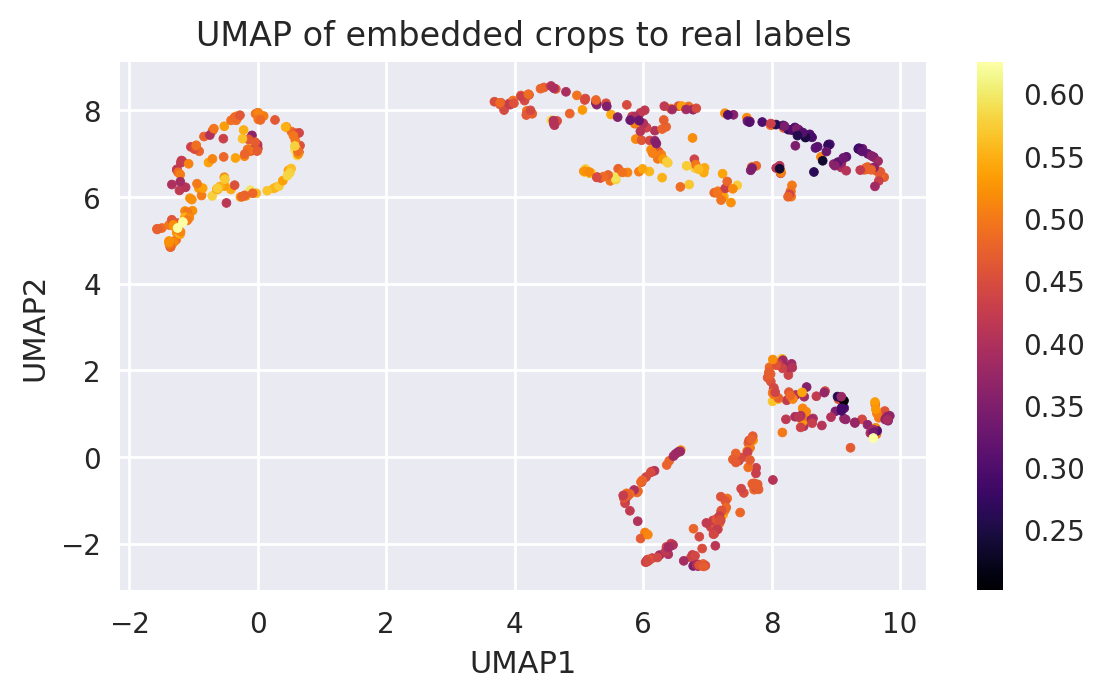

In [26]:
# sample_indicies = np.array(sample_indicies)
fig = plt.figure(figsize=(6.5, 3.5))
plt.scatter(umap_embedded[:, 0], umap_embedded[:, 1], c=morans, s=10, cmap="inferno");
plt.title("UMAP of embedded crops to real labels")
plt.colorbar()
# plt.xticks([])
# plt.yticks([])
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()
fig.savefig("UMAP morans")

## PCA

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

emb_scaled = StandardScaler().fit_transform(embeddings)
pca_embedded = PCA(n_components=2).fit_transform(emb_scaled)

In [31]:
morans[pca_embedded[:, 0] > 0].mean()

0.49116063514972896

In [32]:
morans[pca_embedded[:, 0] < 0].mean()

0.4335056041053148

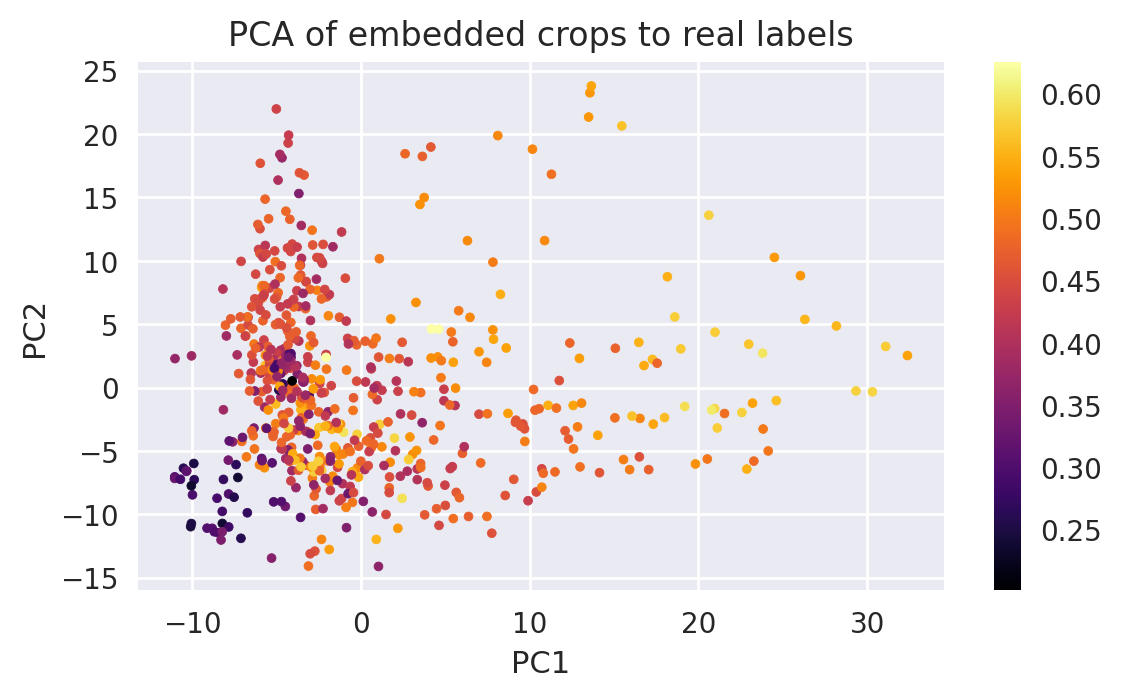

In [30]:
fig = plt.figure(figsize=(6.5, 3.5))
plt.scatter(pca_embedded[:, 0], pca_embedded[:, 1], c=morans, s=10, cmap="inferno");
plt.title("PCA of embedded crops to real labels")
plt.colorbar()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## tSNE

In [38]:
from sklearn.manifold import TSNE

tsne_embedded = TSNE(n_components=2).fit_transform(embeddings)

In [71]:
morans[tsne_embedded[:, 0] > 0].mean()

0.4803412431794877

In [72]:
morans[tsne_embedded[:, 0] < 0].mean()

0.3625441957143336

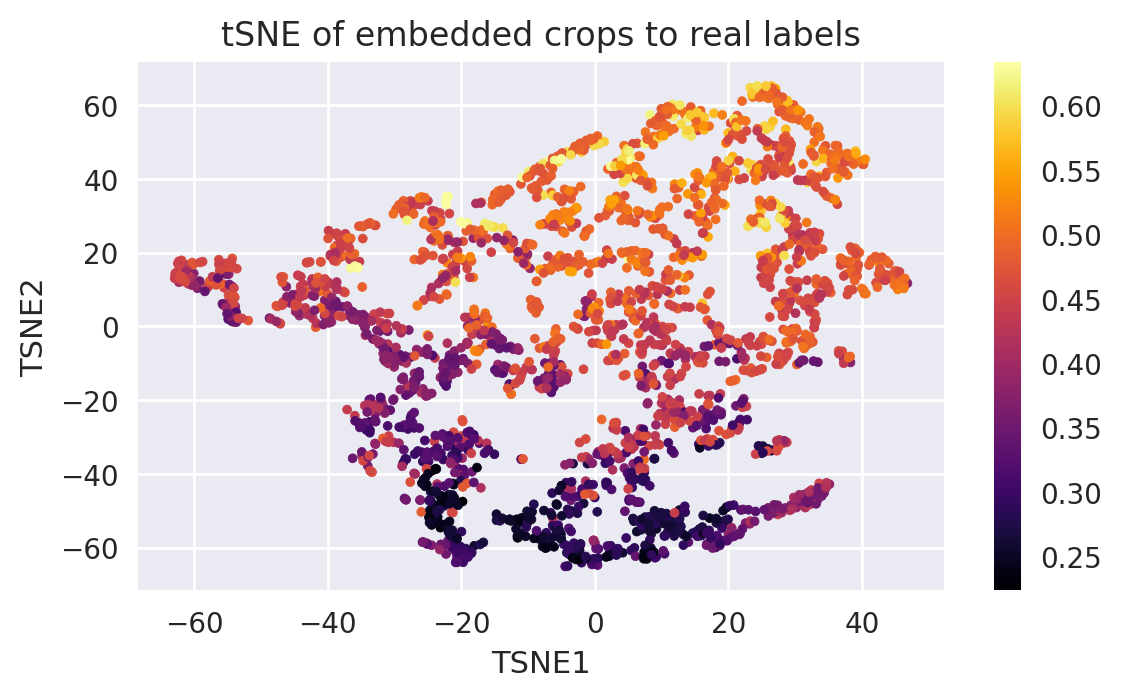

In [39]:
fig = plt.figure(figsize=(6.5, 3.5))
plt.scatter(tsne_embedded[:, 0], tsne_embedded[:, 1], c=morans, s=10, cmap="inferno");
plt.title("tSNE of embedded crops to real labels")
plt.colorbar()
# plt.xticks([])
# plt.yticks([])
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

## Embedding Prediction

In [ ]:
fr